### Imports

In [38]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.1 MB/s eta 0:00:00


In [132]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kshitijaajaglan","key":"a9baae3cd659fcf3c7e9f10d69b3a077"}'}

In [17]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [18]:
!chmod 600 ~/.kaggle/kaggle.json

In [19]:
! kaggle datasets list

ref                                                                title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide               Covid Cases and Deaths WorldWide                  8KB  2023-02-01 12:22:51           6278        189  1.0              
amaanansari09/top-100-songs                                        Top 100 songs                                     6KB  2023-02-16 18:55:35            912         34  1.0              
datascientistanna/customers-dataset                                Shop Customer Data                               23KB  2023-02-07 18:42:21           4861        122  1.0              
thedevastator/airbnb-prices-in-european-cities                   

In [32]:
# ! cd ~/.kaggle
! kaggle datasets download -d ifigotin/imagenetmini-1000 --force

100% 3.91G/3.92G [00:32<00:00, 143MB/s]
100% 3.92G/3.92G [00:32<00:00, 131MB/s]


In [ ]:
! unzip imagenetmini-1000.zip

In [39]:
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import SGD
import tensorflow_addons as tfa
import tqdm
from keras.models import Model
import pylab as plt
import cv2
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import pandas as pd
import numpy as np
import plotly.express as px

In [40]:
(train_X, train_y), (test_X, test_y) = cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [41]:
tqdm_callback = tfa.callbacks.TQDMProgressBar()

In [42]:
print(f"Train: X={train_X.shape}, y={train_y.shape}")
print(f"Test: X={test_X.shape}, y={test_y.shape}")

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


In [6]:
f1_metric = tfa.metrics.F1Score(num_classes=10)

**Example images**

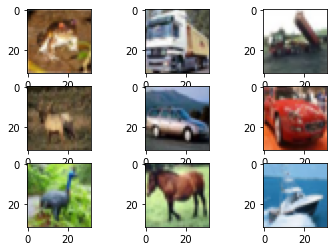

In [7]:
for i in range(9):
    plt.subplot(330 + 1 + i) # TODO how does this work??
    plt.imshow(train_X[i])
plt.show()

Applying one-hot encoding

In [8]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

Normalising pixels

In [9]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

train_X /= 255.0
test_X /= 255.0

### Utility functions

In [54]:
def feature_vis(model, layer, img):
    target_img_size = (32, 32)
    img = cv2.resize(img, target_img_size)
    img = np.expand_dims(img, axis=0)
    # img /= 255.0
    # plt.imshow(img[0, :, :, 2])
    # this_layer = model.get_layer(layer)
    # l_output = this_layer.output

    feature_map_model = Model(model.inputs, model.layers[layer].output)
    features = feature_map_model.predict(img, verbose=0)

    return features

In [94]:
def visualise_feature_map(model, layer, img):
    num_filters = feature_vis(model, layer, img).shape[-1]

    fig, axs = plt.subplots(nrows=2, ncols=num_filters//2, figsize=(num_filters//2, 3))
    axs = axs.flatten()

    for i in range(num_filters):
        axs[i].imshow(feature_vis(model, layer, img)[0, :, :, i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [75]:
def preprocess_history(h):
    res = h
    res['f1_score'] = [np.mean(i) for i in h['f1_score']]
    res['val_f1_score'] = [np.mean(i) for i in h['val_f1_score']]
    return res

In [85]:
def plot_histories(h_arr, h_labels):
    processed_h = []
    metrics = h_arr[0].history.keys()
    print(metrics)
    all_dfs = {}
    for h in h_arr:
        processed_h.append(preprocess_history(h.history))


    for m in metrics:
        df_history = pd.DataFrame()
        for idx, val in enumerate(h_labels):
            df_history[val] = processed_h[idx][m]

        all_dfs[m] = df_history

    return all_dfs

### Defining a basic model


In [10]:
def define_basic_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    return model

In [ ]:
model = define_basic_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(
    train_X, 
    train_y, 
    epochs=10,
    callbacks=[tqdm_callback], verbose=0)

In [12]:
model.evaluate(test_X, test_y)

313/313 [==============================] - 1s 3ms/step - loss: 0.9181 - accuracy: 0.7008


[0.9181408882141113, 0.7008000016212463]

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

### Visualising feature maps

In [44]:
model.input.shape

TensorShape([None, 32, 32, 3])

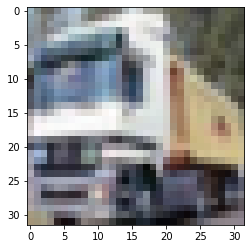

In [60]:
plt.imshow(train_X[1])

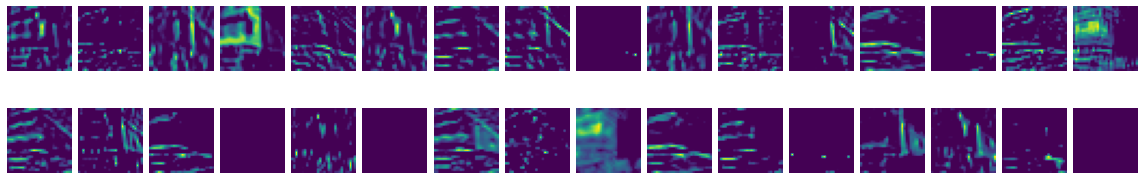

In [95]:
visualise_feature_map(model, 0, train_X[1])

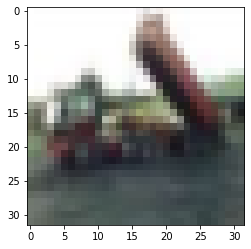

In [96]:
plt.imshow(train_X[2])

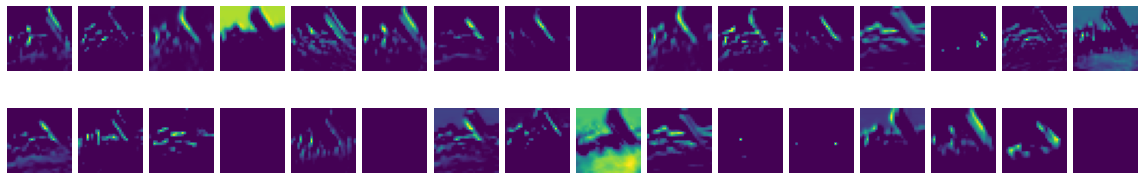

In [97]:
visualise_feature_map(model, 0, train_X[2])

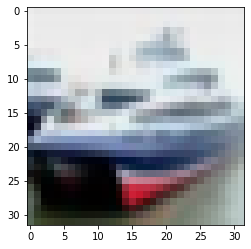

In [98]:
plt.imshow(test_X[1])

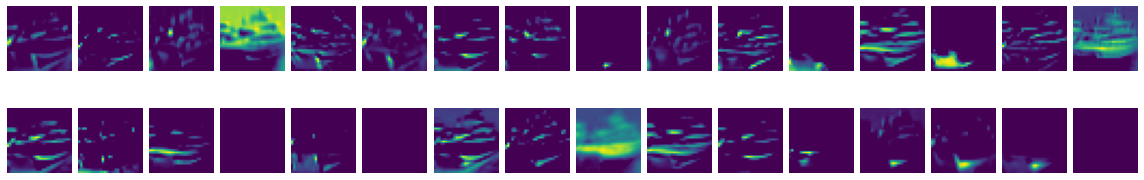

In [99]:
visualise_feature_map(model, 0, test_X[1])

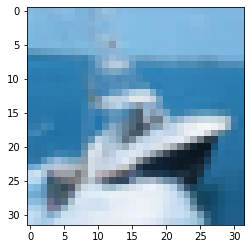

In [100]:
plt.imshow(train_X[8])

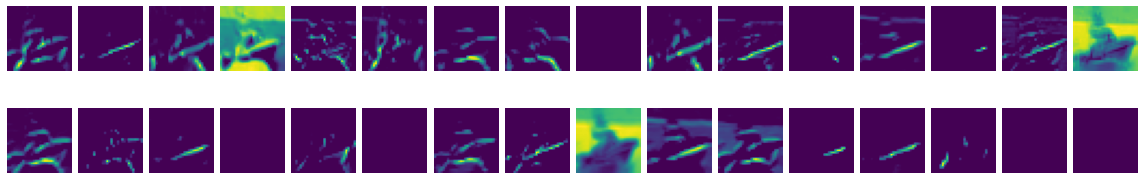

In [101]:
visualise_feature_map(model, 0, train_X[8])

### 3. Experiments

In [20]:
def define_model(type="normal"):
    if type == "normal":
        model = Sequential()
        model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(10, activation='softmax'))

    elif type == "a_more_conv":
        model = Sequential()
        model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)))
        model.add(Conv2D(16, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(10, activation='softmax'))

    elif type == "a_less_conv":
        model = Sequential()
        model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(10, activation='softmax'))

    elif type == "b_less_filters":
        model = Sequential()
        model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(32, 32, 3)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(16, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(16, (3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(16, activation='relu'))
        model.add(Dense(10, activation='softmax'))


    elif type == "b_more_filters":
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dense(10, activation='softmax'))

    elif type == "c_dropout_1":
        model = Sequential()
        model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.1))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.1))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(Dropout(0.1))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(10, activation='softmax'))

    elif type == "c_dropout_2":
        model = Sequential()
        model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dense(10, activation='softmax'))


    return model

In [21]:
basic_model = define_model(type="normal")
basic_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_metric])
basic_history = basic_model.fit(
    train_X, 
    train_y, 
    epochs=10,
    validation_split=0.1)

Epoch 1/10


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


1407/1407 [==============================] - 11s 6ms/step - loss: 1.6453 - accuracy: 0.3953 - f1_score: 0.3848 - val_loss: 1.3812 - val_accuracy: 0.5012 - val_f1_score: 0.4905
Epoch 2/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3139 - accuracy: 0.5275 - f1_score: 0.5226 - val_loss: 1.2077 - val_accuracy: 0.5754 - val_f1_score: 0.5741
Epoch 3/10
1407/1407 [==============================] - 8s 5ms/step - loss: 1.1754 - accuracy: 0.5814 - f1_score: 0.5781 - val_loss: 1.1329 - val_accuracy: 0.5960 - val_f1_score: 0.5879
Epoch 4/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.0923 - accuracy: 0.6126 - f1_score: 0.6099 - val_loss: 1.0641 - val_accuracy: 0.6232 - val_f1_score: 0.6199
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0367 - accuracy: 0.6335 - f1_score: 0.6312 - val_loss: 1.0374 - val_accuracy: 0.6402 - val_f1_score: 0.6355
Epoch 6/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.99

In [22]:
basic_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 32)          9248      
                                                                 
 flatten_1 (Flatten)         (None, 512)              

In [23]:
basic_model.evaluate(test_X, test_y)

313/313 [==============================] - 1s 4ms/step - loss: 0.9781 - accuracy: 0.6604 - f1_score: 0.6617


[0.978072464466095,
 0.6603999733924866,
 array([0.6763754 , 0.77993524, 0.5395561 , 0.510264  , 0.5988806 ,
        0.54024255, 0.7563452 , 0.695692  , 0.76650715, 0.75359344],
       dtype=float32)]

In [24]:
more_conv_model = define_model(type="a_more_conv")

In [25]:
more_conv_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_metric])
more_conv_history = more_conv_model.fit(
    train_X, 
    train_y, 
    epochs=10,
    validation_split=0.1)

Epoch 1/10
1407/1407 [==============================] - 15s 7ms/step - loss: 1.7044 - accuracy: 0.3614 - f1_score: 0.4092 - val_loss: 1.4549 - val_accuracy: 0.4694 - val_f1_score: 0.4510
Epoch 2/10
1407/1407 [==============================] - 10s 7ms/step - loss: 1.3659 - accuracy: 0.5052 - f1_score: 0.4989 - val_loss: 1.2197 - val_accuracy: 0.5538 - val_f1_score: 0.5492
Epoch 3/10
1407/1407 [==============================] - 12s 8ms/step - loss: 1.2066 - accuracy: 0.5648 - f1_score: 0.5610 - val_loss: 1.1703 - val_accuracy: 0.5882 - val_f1_score: 0.5832
Epoch 4/10
1407/1407 [==============================] - 12s 8ms/step - loss: 1.0886 - accuracy: 0.6131 - f1_score: 0.6110 - val_loss: 1.0060 - val_accuracy: 0.6400 - val_f1_score: 0.6411
Epoch 5/10
1407/1407 [==============================] - 12s 8ms/step - loss: 1.0021 - accuracy: 0.6463 - f1_score: 0.6448 - val_loss: 0.9652 - val_accuracy: 0.6580 - val_f1_score: 0.6611
Epoch 6/10
1407/1407 [==============================] - 10s 7ms/s

In [26]:
more_conv_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 conv2d_9 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                  

In [27]:
more_conv_model.evaluate(test_X, test_y)

313/313 [==============================] - 1s 4ms/step - loss: 0.8981 - accuracy: 0.6893 - f1_score: 0.6903


[0.8981303572654724,
 0.689300000667572,
 array([0.7263969 , 0.8391813 , 0.5549857 , 0.50686103, 0.5907797 ,
        0.590706  , 0.7717503 , 0.7151651 , 0.8116232 , 0.79590845],
       dtype=float32)]

In [28]:
less_conv_model = define_model(type="a_less_conv")
less_conv_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_metric])
less_conv_history = less_conv_model.fit(
    train_X, 
    train_y, 
    epochs=10,
    validation_split=0.1)

Epoch 1/10
1407/1407 [==============================] - 9s 5ms/step - loss: 1.5045 - accuracy: 0.4579 - f1_score: 0.4959 - val_loss: 1.2250 - val_accuracy: 0.5708 - val_f1_score: 0.5685
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.1680 - accuracy: 0.5861 - f1_score: 0.5831 - val_loss: 1.1087 - val_accuracy: 0.6128 - val_f1_score: 0.6110
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.0454 - accuracy: 0.6316 - f1_score: 0.6291 - val_loss: 1.0214 - val_accuracy: 0.6486 - val_f1_score: 0.6415
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.9638 - accuracy: 0.6634 - f1_score: 0.6614 - val_loss: 1.0270 - val_accuracy: 0.6482 - val_f1_score: 0.6426
Epoch 5/10
1407/1407 [==============================] - 8s 5ms/step - loss: 0.9081 - accuracy: 0.6842 - f1_score: 0.6826 - val_loss: 1.0118 - val_accuracy: 0.6518 - val_f1_score: 0.6462
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - 

In [29]:
less_conv_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 32)        4640      
                                                                 
 flatten_3 (Flatten)         (None, 5408)              0         
                                                                 
 dense_6 (Dense)             (None, 32)                173088    
                                                                 
 dense_7 (Dense)             (None, 10)                330       
                                                      

In [30]:
less_conv_model.evaluate(test_X, test_y)

313/313 [==============================] - 1s 3ms/step - loss: 1.0025 - accuracy: 0.6607 - f1_score: 0.6600


[1.0024501085281372,
 0.6607000231742859,
 array([0.6923077 , 0.7939086 , 0.5338242 , 0.5010041 , 0.58774227,
        0.5528365 , 0.69487476, 0.7196348 , 0.77159876, 0.75251514],
       dtype=float32)]

In [31]:
more_filters_model = define_model(type="b_more_filters")
more_filters_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_metric])
more_filters_history = more_filters_model.fit(
    train_X, 
    train_y, 
    epochs=10,
    validation_split=0.1)

Epoch 1/10
1407/1407 [==============================] - 11s 6ms/step - loss: 1.5408 - accuracy: 0.4399 - f1_score: 0.4749 - val_loss: 1.3931 - val_accuracy: 0.4958 - val_f1_score: 0.4825
Epoch 2/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.1659 - accuracy: 0.5865 - f1_score: 0.5835 - val_loss: 1.0396 - val_accuracy: 0.6336 - val_f1_score: 0.6327
Epoch 3/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.0056 - accuracy: 0.6448 - f1_score: 0.6427 - val_loss: 0.9365 - val_accuracy: 0.6736 - val_f1_score: 0.6741
Epoch 4/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.9055 - accuracy: 0.6820 - f1_score: 0.6802 - val_loss: 0.8936 - val_accuracy: 0.6914 - val_f1_score: 0.6894
Epoch 5/10
1407/1407 [==============================] - 9s 6ms/step - loss: 0.8378 - accuracy: 0.7066 - f1_score: 0.7055 - val_loss: 0.8497 - val_accuracy: 0.7026 - val_f1_score: 0.7006
Epoch 6/10
1407/1407 [==============================] - 9s 6ms/step -

In [32]:
more_filters_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_4 (Flatten)         (None, 1024)             

In [33]:
more_filters_model.evaluate(test_X, test_y)

313/313 [==============================] - 1s 5ms/step - loss: 0.8904 - accuracy: 0.7054 - f1_score: 0.7017


[0.8903592824935913,
 0.7053999900817871,
 array([0.73368776, 0.8342912 , 0.6087348 , 0.5159516 , 0.6594274 ,
        0.5744934 , 0.7558886 , 0.75104696, 0.79115486, 0.7919922 ],
       dtype=float32)]

In [34]:
less_filters_model = define_model(type="b_less_filters")
less_filters_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_metric])
less_filters_history = less_filters_model.fit(
    train_X, 
    train_y, 
    epochs=10,
    validation_split=0.1)

Epoch 1/10
1407/1407 [==============================] - 10s 6ms/step - loss: 1.7710 - accuracy: 0.3461 - f1_score: 0.4057 - val_loss: 1.5183 - val_accuracy: 0.4456 - val_f1_score: 0.4383
Epoch 2/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.4684 - accuracy: 0.4659 - f1_score: 0.4592 - val_loss: 1.4069 - val_accuracy: 0.4926 - val_f1_score: 0.4815
Epoch 3/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3711 - accuracy: 0.5053 - f1_score: 0.5002 - val_loss: 1.3272 - val_accuracy: 0.5168 - val_f1_score: 0.5166
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 1.3062 - accuracy: 0.5334 - f1_score: 0.5292 - val_loss: 1.2550 - val_accuracy: 0.5504 - val_f1_score: 0.5483
Epoch 5/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.2538 - accuracy: 0.5541 - f1_score: 0.5506 - val_loss: 1.2283 - val_accuracy: 0.5584 - val_f1_score: 0.5481
Epoch 6/10
1407/1407 [==============================] - 8s 6ms/step -

In [35]:
less_filters_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 30, 30, 8)         224       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 8)        0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 13, 13, 16)        1168      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 4, 4, 16)          2320      
                                                                 
 flatten_5 (Flatten)         (None, 256)              

In [36]:
less_filters_model.evaluate(test_X, test_y)

313/313 [==============================] - 1s 3ms/step - loss: 1.1677 - accuracy: 0.5850 - f1_score: 0.5718


[1.1676702499389648,
 0.5849999785423279,
 array([0.622     , 0.69193155, 0.492233  , 0.3705058 , 0.43712965,
        0.4796275 , 0.64962643, 0.6465677 , 0.6947988 , 0.6338857 ],
       dtype=float32)]

In [37]:
dropout_1_model = define_model(type="c_dropout_1")
dropout_1_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_metric])
dropout_1_history = dropout_1_model.fit(
    train_X, 
    train_y, 
    epochs=10,
    validation_split=0.1)

Epoch 1/10
1407/1407 [==============================] - 13s 8ms/step - loss: 1.6944 - accuracy: 0.3796 - f1_score: 0.4095 - val_loss: 1.5189 - val_accuracy: 0.4400 - val_f1_score: 0.4313
Epoch 2/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3987 - accuracy: 0.4963 - f1_score: 0.4911 - val_loss: 1.2814 - val_accuracy: 0.5364 - val_f1_score: 0.5279
Epoch 3/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.2868 - accuracy: 0.5397 - f1_score: 0.5362 - val_loss: 1.2055 - val_accuracy: 0.5788 - val_f1_score: 0.5754
Epoch 4/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.2080 - accuracy: 0.5680 - f1_score: 0.5649 - val_loss: 1.0898 - val_accuracy: 0.6150 - val_f1_score: 0.6126
Epoch 5/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.1460 - accuracy: 0.5892 - f1_score: 0.5864 - val_loss: 1.0554 - val_accuracy: 0.6186 - val_f1_score: 0.6205
Epoch 6/10
1407/1407 [==============================] - 8s 6ms/step -

In [38]:
dropout_1_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 15, 15, 16)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 15, 15, 16)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 32)         

In [39]:
dropout_1_model.evaluate(test_X, test_y)

313/313 [==============================] - 2s 6ms/step - loss: 0.9704 - accuracy: 0.6647 - f1_score: 0.6619


[0.9703555703163147,
 0.6646999716758728,
 array([0.69125295, 0.78153265, 0.53339744, 0.486653  , 0.57061833,
        0.5695932 , 0.75575036, 0.7221172 , 0.7745005 , 0.7336538 ],
       dtype=float32)]

In [40]:
dropout_2_model = define_model(type="c_dropout_1")
dropout_2_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', f1_metric])
dropout_2_history = dropout_2_model.fit(
    train_X, 
    train_y, 
    epochs=10,
    validation_split=0.1)

Epoch 1/10
1407/1407 [==============================] - 13s 7ms/step - loss: 1.6669 - accuracy: 0.3877 - f1_score: 0.4300 - val_loss: 1.3773 - val_accuracy: 0.4982 - val_f1_score: 0.4841
Epoch 2/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.3484 - accuracy: 0.5135 - f1_score: 0.5090 - val_loss: 1.2323 - val_accuracy: 0.5566 - val_f1_score: 0.5494
Epoch 3/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.2256 - accuracy: 0.5636 - f1_score: 0.5608 - val_loss: 1.1216 - val_accuracy: 0.6098 - val_f1_score: 0.5981
Epoch 4/10
1407/1407 [==============================] - 9s 6ms/step - loss: 1.1390 - accuracy: 0.5950 - f1_score: 0.5926 - val_loss: 1.0542 - val_accuracy: 0.6246 - val_f1_score: 0.6238
Epoch 5/10
1407/1407 [==============================] - 8s 6ms/step - loss: 1.0904 - accuracy: 0.6140 - f1_score: 0.6120 - val_loss: 1.0342 - val_accuracy: 0.6320 - val_f1_score: 0.6340
Epoch 6/10
1407/1407 [==============================] - 9s 6ms/step -

In [41]:
dropout_2_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 15, 15, 16)       0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 16)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 6, 6, 32)         

In [42]:
dropout_2_model.evaluate(test_X, test_y)

313/313 [==============================] - 1s 3ms/step - loss: 0.9105 - accuracy: 0.6824 - f1_score: 0.6794


[0.9105441570281982,
 0.6823999881744385,
 array([0.71694416, 0.79962015, 0.5537493 , 0.4881321 , 0.6351681 ,
        0.5821295 , 0.7642276 , 0.7287532 , 0.77242   , 0.7532334 ],
       dtype=float32)]

### 3.1. Analyzing f1 score and other metrics

In [77]:
h_arr = [basic_history, more_conv_history, less_conv_history, more_filters_history, less_filters_history, dropout_1_history, dropout_2_history]
h_labels = ["basic", "more_conv", "less_conv", "more_filters", "less_filters", "dropout 0.1", "dropout 0.2"]

**1. (mean) f1 score**

In [91]:
px.line(plot_histories(h_arr, h_labels)["f1_score"], labels = {'x':"epoch", 'y':"f1_score"}, title="Training f1 scores")

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])


In [103]:
px.line(plot_histories(h_arr, h_labels)["val_f1_score"], labels = {'x':"epoch", 'y':"val_f1_score"}, title="Validation f1 scores")

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])


For training f1 scores, we see a pretty consistent trend among the models, with f1 score of model with more filters going the highest, and the lowest being the one with less filters. There was also a slight increase with increase in dropout parameter. Interestingly, f1 score of less conv model was higher than that with more conv layers.



For validation however, the curves weren't consistenly smooth. The f1 score of less_filters dropped drastically in comparison to training, but more_filters was still the highest. In comparison to the basic model, every other model except less_filters, and dropout_0.1 (to an extent) have a better f1 score

**2. Training times (per epoch)**

In [140]:
training_times = {
    "basic": [11, 8, 8, 9, 7, 8, 8, 8, 8, 8],
    "more_conv": [15, 10, 12, 12, 12, 10, 10, 10, 10, 10],
    "less_conv": [9, 7, 7, 7, 8, 7, 8, 7, 8, 8],
    "more_filters": [11, 9, 9, 8, 9, 9, 8, 9, 9, 8],
    "less_filters": [10, 8, 8, 7, 8, 8, 8, 8, 8, 10],
    "dropout 0.1": [13, 8, 8, 9, 8, 8, 9, 8, 8, 11],
    "dropout 0.2": [13, 8, 9, 9, 8, 9, 8, 8, 9, 9]
    }
df_time = pd.DataFrame(training_times)

In [161]:
px.line(df_time, title="Training time per epoch", labels = {'x':"epoch", 'y':"time taken"})

**Observations:**
As expected intuitively, the model with less conv layers took the least time, and that with more layers took the most time due to more computation involved. Moreover, adding more filters also increases the training time. Not much difference was seen by adding/changing values of dropout

**3. Accuracy**

In [120]:
px.line(plot_histories(h_arr, h_labels)["accuracy"], title="Training accuracy", labels = {'x':"epoch", 'y':"accuracy"})

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])


In [118]:
px.line(plot_histories(h_arr, h_labels)["val_accuracy"], title="Validation accuracy", labels = {'x':"epoch", 'y':"val_accuracy"})

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])


Looking at the graphs above, more-filters seems to have the best accuracy, and less_filters has the worst accuracy -- consistent with trends in f1 score. This might be attributed to more "capacity" to learn various characteristics

Interestingly, both accuracy and f1 score of less_conv are greater than that of more_conv


Overall, the number of filters seem to have more effect on accuracy and f1 score than the number of conv layers

### 3.2 Visualising layers

#### Initial and final layers

We shall be using the fifth image from test set for comparing initial and final layer feature maps

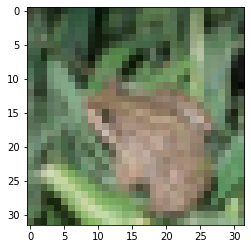

In [109]:
plt.imshow(test_X[4])

**1. Basic model**

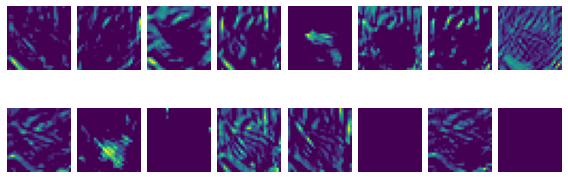

In [110]:
visualise_feature_map(basic_model, 0, test_X[4])

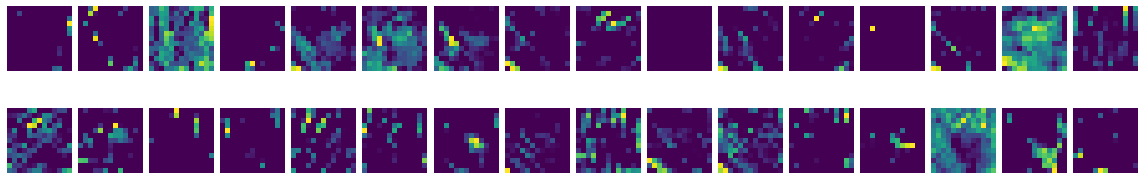

In [112]:
visualise_feature_map(basic_model, 2, test_X[4])

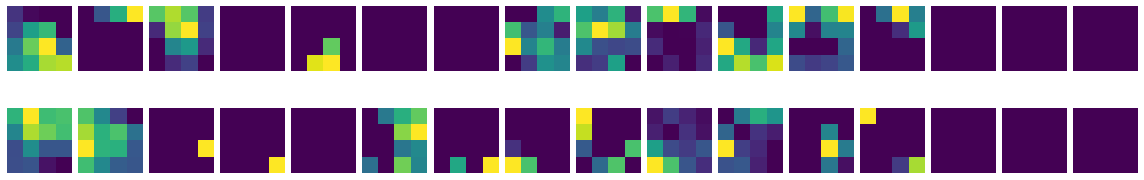

In [111]:
visualise_feature_map(basic_model, 4, test_X[4])

**2. More conv layers (double)**

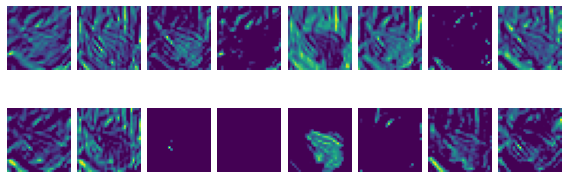

In [113]:
visualise_feature_map(more_conv_model, 0, test_X[4])

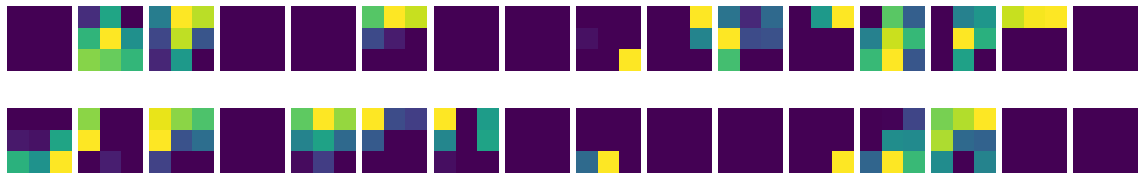

In [117]:
visualise_feature_map(more_conv_model, 6, test_X[4])

**3. Less conv layers (two)**

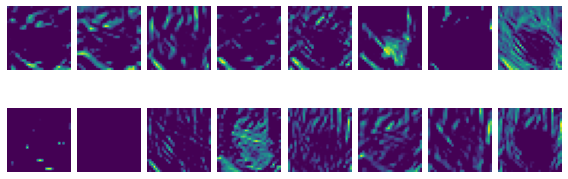

In [121]:
visualise_feature_map(less_conv_model, 0, test_X[4])

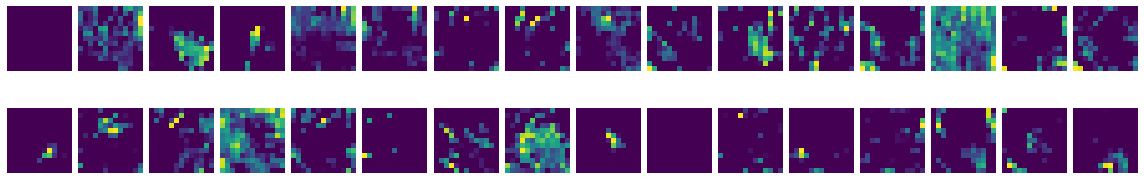

In [122]:
visualise_feature_map(less_conv_model, 2, test_X[4])

**4. More filters (double)**

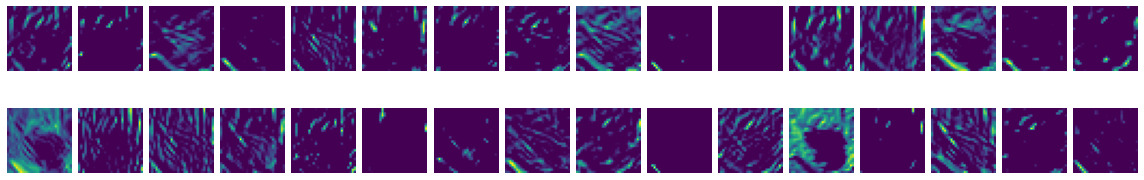

In [123]:
visualise_feature_map(more_filters_model, 0, test_X[4])

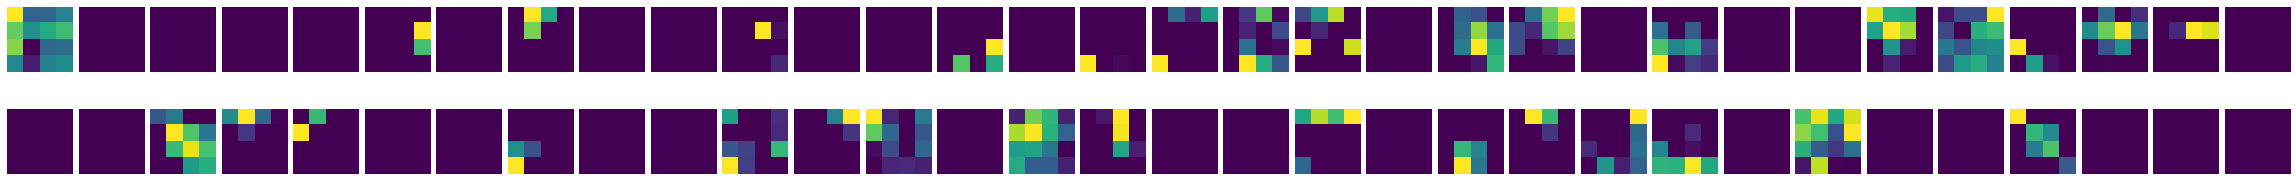

In [125]:
visualise_feature_map(more_filters_model, 4, test_X[4])

**5. Less filters (half)**

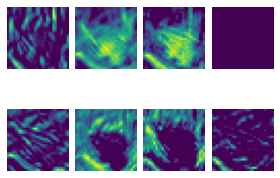

In [126]:
visualise_feature_map(less_filters_model, 0, test_X[4])

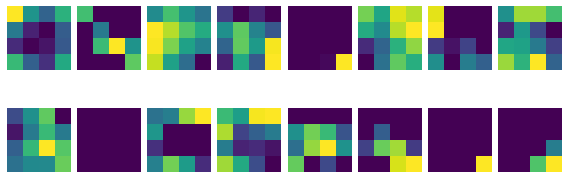

In [127]:
visualise_feature_map(less_filters_model, 4, test_X[4])

**6. Dropout at 0.1 after every MaxPool**

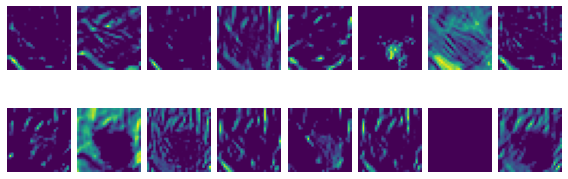

In [128]:
visualise_feature_map(dropout_1_model, 0, test_X[4])

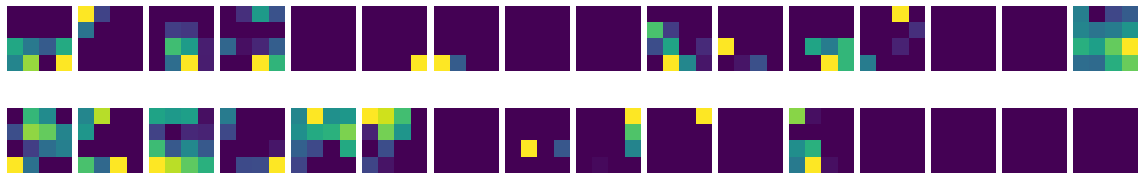

In [129]:
visualise_feature_map(dropout_1_model, 6, test_X[4])

**7. Dropout at 0.2 after every MaxPool**

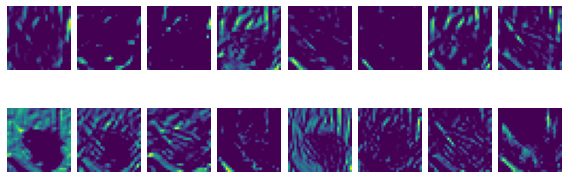

In [130]:
visualise_feature_map(dropout_2_model, 0, test_X[4])

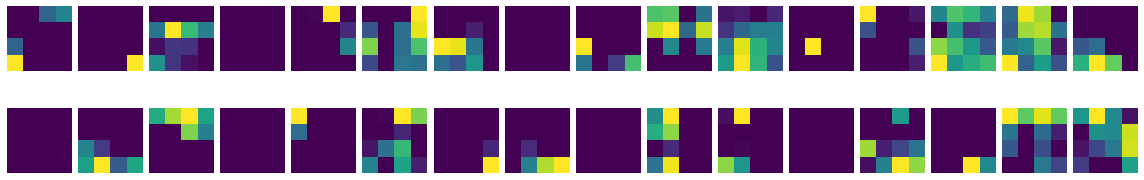

In [131]:
visualise_feature_map(dropout_2_model, 6, test_X[4])

In all the cases above, the first layers seem to show a good represntation of the original image, but by the end the features don't seem to be human interpretable.
Some blocks however correspond to different elements like grass, frog etc. as seen above

#### Different classes

**Class 0: frog**

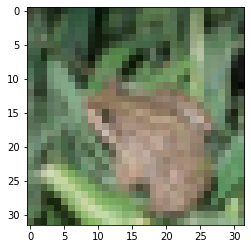

In [144]:
plt.imshow(test_X[4])

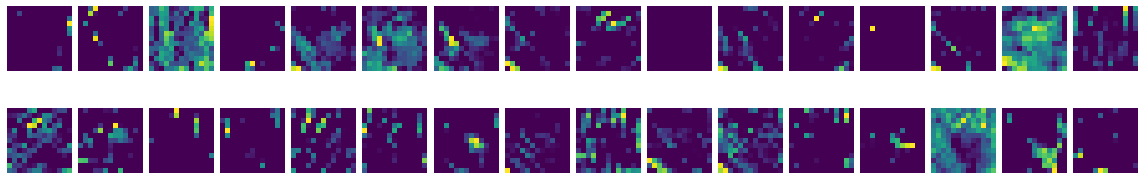

In [153]:
visualise_feature_map(basic_model, 2, test_X[4])

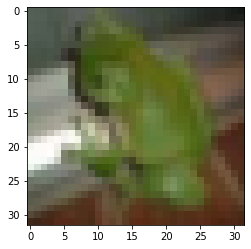

In [147]:
plt.imshow(test_X[7])

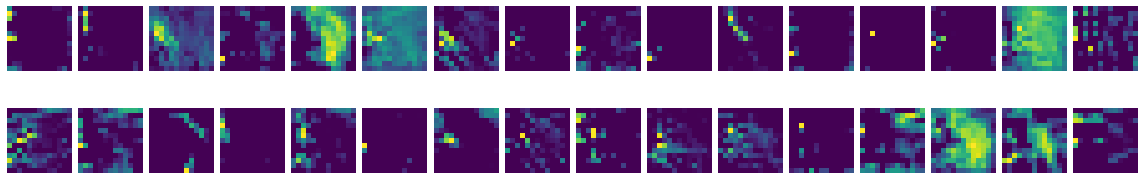

In [154]:
visualise_feature_map(basic_model, 2, test_X[7])

**Observations:**

Here, we can identify two properties which are being learnt.
1. The third last cell in bottom row seems to recognise green colour and is focussing on that. In the top image, the frog is brown and surroundings are green, whereas in the bottom one it's the opposite. This seems to have been captured well
2. The sixth cell in top row seems to identify eyes and seems pretty similar to the seventh block in same row

**Class 2: ship**

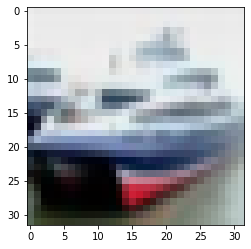

In [148]:
plt.imshow(test_X[1])

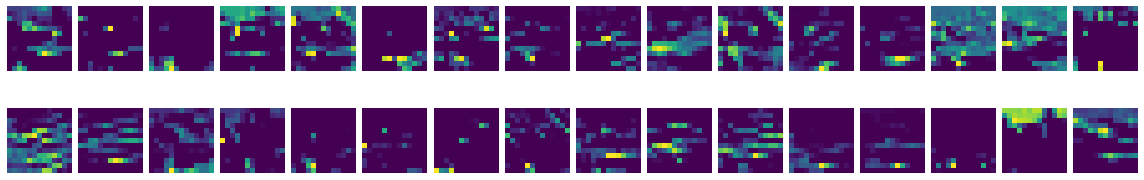

In [157]:
visualise_feature_map(basic_model, 2, test_X[1])

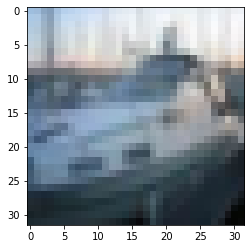

In [149]:
plt.imshow(test_X[2])

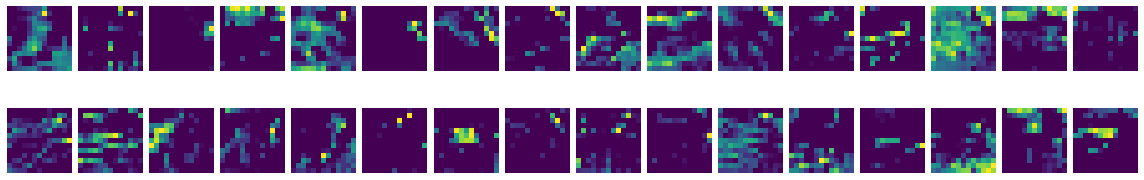

In [158]:
visualise_feature_map(basic_model, 2, test_X[2])

**Observations:**

Here, the fourth cell in top row seems to identify sky for both the images

**Class 2: cat**

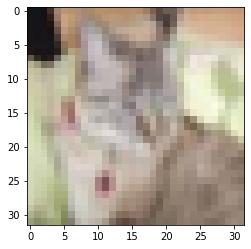

In [150]:
plt.imshow(test_X[8])

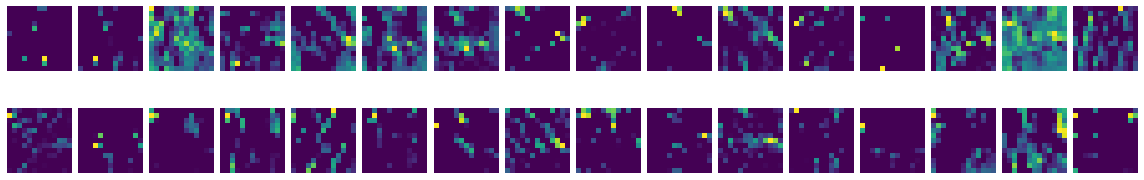

In [159]:
visualise_feature_map(basic_model, 2, test_X[8])

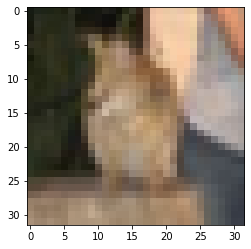

In [168]:
plt.imshow(test_X[46])

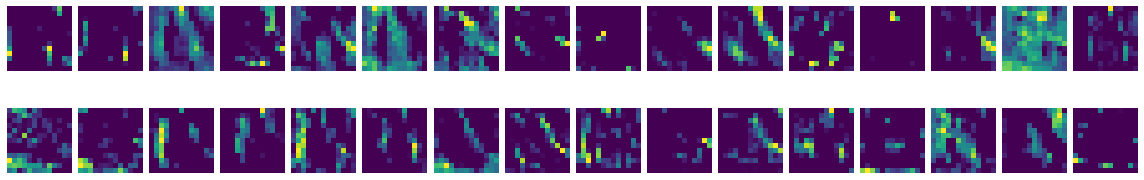

In [169]:
visualise_feature_map(basic_model, 2, test_X[46])

**Observations:**

The second last cell in bottom row seems to identify the overall shape of the cat

###4. Classification model

In [2]:
import os
from PIL import Image
import numpy as np

In [9]:
class DataLoader():
    def __init__(self, train_path, test_path):
        self.train_path = train_path
        self.test_path = test_path
        self.train_X = []
        self.train_y = []
        self.test_X = []
        self.test_y = []

        # self.read_train()
        self.read_test()


    def read_train(self):
        for label in os.listdir(self.train_path):
            for i in os.listdir(os.path.join(self.train_path, label)):
                # print(label, i)
                img = Image.open(os.path.join(self.train_path, label, i))
                img.load()
                data = np.asarray(img, dtype='uint8')

                self.train_X.append(data)
                self.train_y.append(label)

    
    def read_test(self):
        for label in os.listdir(self.test_path):
            for i in os.listdir(os.path.join(self.test_path, label)):
                # print(label, i)
                img = Image.open(os.path.join(self.test_path, label, i))
                img.load()
                data = np.asarray(img, dtype='uint8')

                self.test_X.append(data)
                self.test_y.append(label)

In [ ]:
dl = DataLoader("imagenet-mini/train", "imagenet-mini/val")